In [2]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import re
import mne
import pathlib
import openpyxl
from datetime import datetime
import pytz
import random
import os
from scipy import signal
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
import matplotlib
from matplotlib import pyplot as plt
import psutil
import gc



print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Init Plugin
Init Graph Optimizer
Init Kernel
Tensor Flow Version: 2.5.0
Keras Version: 2.5.0

Python 3.9.7 (default, Sep 16 2021, 23:53:23) 
[Clang 12.0.0 ]
Pandas 1.3.1
Scikit-Learn 0.24.2
GPU is available


Globals

In [24]:
list1 = {"data": [1,2,3,4,5,6,7], "class": ['a', 'a', 'a', 'c', 'c', 'b', 'b' ]}

df = pd.DataFrame(list1)

In [25]:
df

,data,class
0,1,a
1,2,a
2,3,a
3,4,c
4,5,c
5,6,b
6,7,b


In [26]:
df = df[df['class'].isin(['b','a'])]
df

,data,class
0,1,a
1,2,a
2,3,a
5,6,b
6,7,b


In [24]:
cwd = os.getcwd()
FREQ = 500
database_path = 'Dataset/CHB-MIT/chb-mit-scalp-eeg-database-1.0.0/'
filtered_database_path = 'Dataset/CHB-MIT/Filtered-chb-mit/'
external_hardisk_drive_path = os.path.dirname('/Volumes/LaCie/Database/')
edf_file_type = ".edf"
compressed_file_type = ".parquet.gzip"
file = "/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/ECG/patient_4_date_2019-05-20 1102590000.csv"


In [22]:
def get_info_text():
    with open("/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/EEG/info.txt", 'r') as f:
        str_container = ""
        formatted_str = []
        for line in f:
            str_container += str(line).replace("\n", "<br>")
            formatted_str = re.findall('(.*?)<br><br>', str_container)
        return formatted_str

info_obj = get_info_text()
        

In [30]:
names = "/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/EEG/patient_21_date_2020-06-16 1523290000.csv"

In [24]:
def find_frq(str_obj):
    frq_found = re.search(r"<br> freq: (.*?) <br>", str_obj)
    if(frq_found):
        return int(float(frq_found.group(1)))

def find_filename(str_obj):
    frq_found = re.search(r"filename: (.*?) <br>", str_obj)
    if(frq_found):
        return (frq_found.group(1))

find_frq("filename: patient_4_date_2019-05-21 1556430000 <br> freq: 500.0 <br> channels: ['CH-1', 'CH-2', 'CH-3', 'CH-4', 'CH-5', 'CH-6', 'CH-7', 'CH-8', 'x', 'y', 'z'] ")

500

In [31]:
FREQ = [find_frq(x) for x in info_obj if find_filename(x) in names][0] if len([find_frq(x) for x in info_obj if find_filename(x) in names]) > 0 else 500

In [3]:
def remove_cols(dataframe, col_start = 0, col_end = 0):
    if col_end == 0:
        col_end = len(dataframe.columns) - 1
    
    dataframe = dataframe.iloc[: , col_start: col_end]
    return dataframe

In [4]:
os.getcwd()

'/Users/niklashjort/Desktop/Notes/Speciale/projects/DataHandling/Køge'

In [5]:
for f in os.listdir("/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/EEG"):
    print(f)

patient_21_date_2020-06-15 1120350000.csv
patient_6_date_2019-08-29 0943290000.csv
patient_34_date_2021-02-15 0951300000.csv
.DS_Store
patient_4_date_2019-05-21 1556430000.csv
patient_33_date_2021-02-01 1244260000.csv
info.txt
patient_6_date_2019-08-26 1551140000.csv
patient_21_date_2020-06-17 1402280000.csv
patient_4_date_2019-05-22 0901320000.csv
patient_35_date_2021-03-15 0949180000.csv
patient_21_date_2020-06-17 1059500000.csv
patient_30_date_2020-09-21 0930550000.csv
patient_24_date_2020-11-02 0949020000.csv
patient_28_date_2020-09-07 1109100000.csv
patient_21_date_2020-06-16 1523290000.csv


In [49]:
df = pd.read_csv("/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/EEG/patient_4_date_2019-05-21 1556430000.csv", usecols=[1,2,3])

In [50]:
df.columns

Index(['class', 'timestamp', 'CH-1'], dtype='object')

In [51]:
gc.collect()

8

In [52]:
# print(test_df.info(memory_usage='deep'))
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [53]:
df.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16498999 entries, 0 to 16498998
Columns: 3 entries, class to CH-1
dtypes: float64(3)
memory usage: 377.6 MB


In [54]:
mem_usage(df)

'377.63 MB'

In [36]:
df.dtypes

class        float64
timestamp    float64
CH-1         float64
dtype: object

In [292]:
df.head()

,class,timestamp,CH-1
0,3.0,1.558479e+12,-7.627329e-07
1,3.0,1.558479e+12,-3.163425e-05
2,3.0,1.558479e+12,-4.334413e-05
3,3.0,1.558479e+12,-4.227960e-05
4,3.0,1.558479e+12,-2.311797e-05


In [55]:
def downcast_dtypes(df):
    _start = df.memory_usage(deep=True).sum() / 1024 ** 2
    float_cols = [c for c in df if df[c].dtype == 'float64']
    int_cols = [c for c in df if df[c].dtype in ['int64', 'int32']]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    _end = df.memory_usage(deep=True).sum() / 1024 ** 2
    saved_time = (_start - _end) / _start * 100
    #print(f"Saved: {saved_time:.2f}%")
    return df

In [56]:
df = downcast_dtypes(df)

In [42]:
df['class'].value_counts()

3    13640999
2     2700000
1      158000
Name: class, dtype: int64

In [293]:
df.head()

,class,timestamp,CH-1
0,3.0,1.558479e+12,-7.627329e-07
1,3.0,1.558479e+12,-3.163425e-05
2,3.0,1.558479e+12,-4.334413e-05
3,3.0,1.558479e+12,-4.227960e-05
4,3.0,1.558479e+12,-2.311797e-05


In [40]:
df['class'] = df['class'].astype('int32')

In [43]:
def read_compressed_df(df):

    sz_df = df.loc[df['class'] == 1]

    prei_one_df = df.loc[df['class'] == 2]

    inter_df = df.loc[df['class'] == 3]

    channels = [item for item in list(sz_df.columns) if item != "class" if item != "timestamp"]

    return (sz_df, prei_one_df, inter_df, channels)

In [18]:
def get_window(channel, start_index, data, size = 4, overlap = 0, is_sezure = False, frequency = 500):
    if(is_sezure):
        overlap = 2
    else:
        overlap = overlap
    
    start = start_index * (size - overlap) * frequency
    end = start + (size * frequency)

    date_timestamp = ""

    try:
        date_timestamp = datetime.fromtimestamp((data['timestamp'][start:start+1]/1000).tolist()[0]).strftime('%H:%M:%S')
    except:
        date_timestamp = "datetime cannot be converted"
    
    return [data[channel][start:end].tolist(), date_timestamp]

In [64]:
def get_max_window_iteration(dataframe, buffer):
    len_of_df = int(len(dataframe) // (buffer*FREQ))
    return len_of_df


In [20]:
from scipy import signal

In [44]:
Fs = 500             # Define the sampling frequency,
interval = Fs        # ... the interval size,
overlap = Fs * 0.95  # ... and the overlap intervals

def spec_transform_save_to_folder(index, win, channel, patient_state, patient, plot_title = False):
    plt.figure(figsize=(7,7))
    series = win[0]
    time_of_observation = win[1]
    try:
        series = np.array(series).astype(np.float)
    except Exception as e:
        print(f"error: {e}")
        print(f"patient_state: {patient_state} channel: {channel} index: {index} window: {series}")
    denoised_series = denoise_wavelet(series, method='BayesShrink', mode='soft',rescale_sigma=True, multichannel=False, wavelet_levels=3)
    if plot_title:
        plt.title(f"{channel} : is_seizure = {patient_state} : {time_of_observation}")
    

    f, t, Sxx = signal.spectrogram(denoised_series, fs=Fs, nperseg=interval, noverlap=overlap)
                         
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), cmap='jet')



    #s,f,t,im = plt.specgram(denoised_series,Fs=256)
    #plt.ylim(0, 20)
    #plt.axis('off')
    
    # f, t, Sxx = signal.spectrogram(denoised_series, 1./FREQ, nfft=overlap, nperseg=int(256/2))
    # #plt.pcolormesh(t, f[0:20], Sxx[0:20])
    # plt.pcolormesh(t, f, 10*np.log10(Sxx))
    plt.show()
    # if patient_state == "seizure":
    #     plt.savefig(f'test_data//windows/Seizure2/{patient}_{index}_{channel}_{time_of_observation}.png', edgecolor='none', bbox_inches='tight')
    # elif patient_state == "interictal":
    #     plt.savefig(f'test_data//windows/Interictal/{patient}_{index}_{channel}_{time_of_observation}.png')
    # elif patient_state == "prei_one":
    #     plt.savefig(f'test_data//windows/test/Preictal_One/{patient}_{index}_{channel}_{str(time_of_observation).strip()}.png')
    # elif patient_state == "prei_two":
    #     plt.savefig(f'test_data/windows/Preictal_Two/{patient}_{index}_{channel}_{str(time_of_observation).strip()}.png')
    # plt.show()
    del series
    plt.clf()    
    plt.close()
    gc.collect()

In [45]:
count = 0

print("started file: " + str(file) + " index: " + str(count))
sz, prei_one, inter, selected_channels = read_compressed_df(df)
print(selected_channels)
print(f"len sz {len(sz)}")
print(f"len prei {len(prei_one)}")
patient = re.search('patient_(.*)_date_', file).group(1)
print(patient)
sz_count = 0
int_count = 0
count = 0
sz_win = []
inter_win =[]
for channel in selected_channels:
    if count < 1:
        if len(inter) > 0 and inter.empty == False and int_count < 3:
            inter_win = [get_window(channel=channel,start_index=i, data=inter) for i in range(get_max_window_iteration(inter, 4))]
            # for index, window in enumerate(inter_win):
            #     if int_count > 1:continue
            #     spec_transform_save_to_folder(win=window, index=index, channel=channel, patient_state = "interictal", patient=patient, plot_title=True)
            #     int_count += 1
            

        if len(sz) > 0 and sz.empty == False and sz_count < 3:
            sz_win = [get_window(channel=channel, start_index=i, data=sz, is_sezure=True) for i in range(get_max_window_iteration(sz, 2))]
            # for index, window in enumerate(sz_win):
            #     if sz_count > 1:continue
            #     sz_count += 1
            #     spec_transform_save_to_folder(channel=channel, index=index, win=window, patient_state="seizure", patient=patient, plot_title=True)
            
        count += 1


del sz, prei_one, inter, df

started file: /Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/ECG/patient_4_date_2019-05-20 1102590000.csv index: 0
['CH-1']
len sz 158000
len prei 2700000
4


In [27]:

gc.collect()

8

In [47]:
len(sz_win)

158

In [244]:
sze = sz_win[100][0]
inte = inter_win[1000][0]

In [25]:
time = np.arange(len(inte))/500

In [26]:
nyquist = 500 / 2.
b, a = signal.filter_design.iirfilter(3, (120. / nyquist, 121. / nyquist), rs=10,
                               ftype='cheby2')

In [27]:
xfilt = signal.filtfilt(b, a, sz)

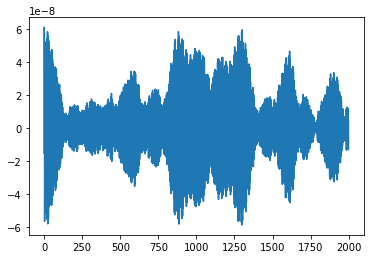

In [28]:
plt.plot(xfilt)

In [29]:
win = 4 * 256
f, psd = signal.welch(sz,
               fs=1./256,  # sample rate
               window='hanning',   # apply a Hanning window before taking the DFT
               nperseg=256,        # compute periodograms of 256-long segments of x
               detrend='constant') # detrend x by subtracting the mean

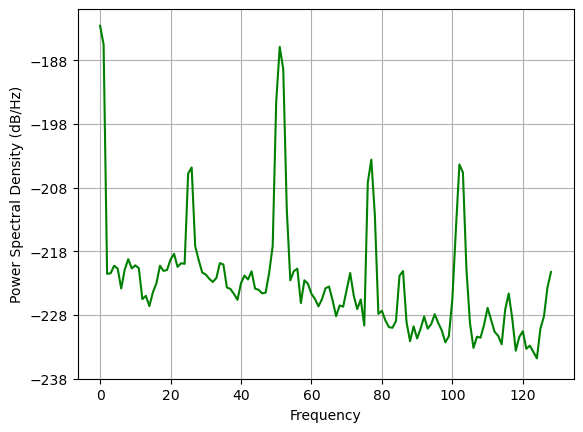

In [30]:
plt.style.use('default')
plt.psd(np.array(sz)**2, Fs=256, color ="green")
lines = plt.gca().get_lines()
x_data = lines[0].get_data()[1]

In [250]:
den_sz = denoise_wavelet(np.array(sze).astype(np.float),wavelet='db8', method='BayesShrink', mode='hard',rescale_sigma=True, multichannel=False, wavelet_levels=3)
den_inte = denoise_wavelet(np.array(inte).astype(np.float),wavelet='db8', method='BayesShrink', mode='soft',rescale_sigma=True, multichannel=False, wavelet_levels=3)


In [32]:
Fs = 256         # Define the sampling frequency,
interval = 256       # ... the interval size,
overlap = interval * 0.99  # ... and the overlap intervals

/usr/local/Caskroom/miniforge/base/envs/speciale_01_01/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


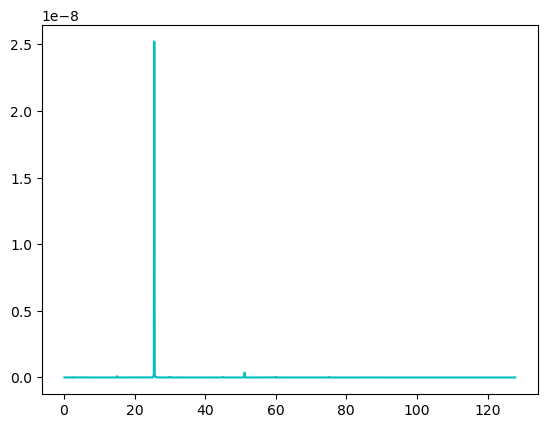

In [33]:
dt = 1/256
n = len(inte)
fhat = np.fft.fft(inte, n)
PSD = fhat * np.conj(fhat / n)
freq = (1/(dt*n)) * np.arange(n)
L = np.arange(1, np.floor(n/2), dtype='int')

plt.plot(freq[L], PSD[L], color='c')

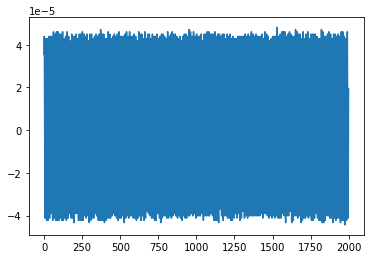

In [63]:
plt.plot(sze)
#plt.plot(den_inte)

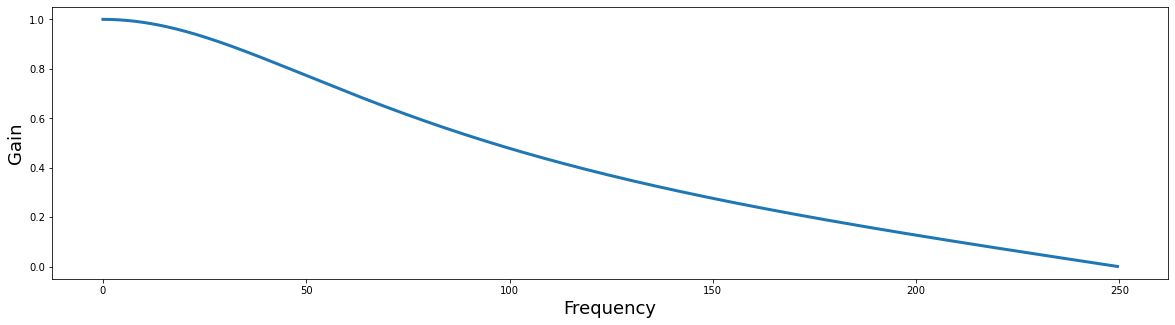

In [273]:
filter_order = 8
frequency_cutoff = 60
sampling_frequency = 500

def rad_sample_to_hz(x, fs):
    return (x*fs)/(2*np.pi)

def plot_filter(b, a, fs):
    plt.figure(figsize=(20,5))
    w, h = signal.freqz(b, a, worN=256*2, whole=False)
    plt.plot(rad_sample_to_hz(w, fs), abs(h), linewidth=3)
    plt.ylabel('Gain', fontsize=18)
    plt.xlabel('Frequency', fontsize=18)

# Create the filter
b, a = signal.butter(1, frequency_cutoff, btype='low', output='ba', fs=sampling_frequency)
plot_filter(b, a, sampling_frequency)

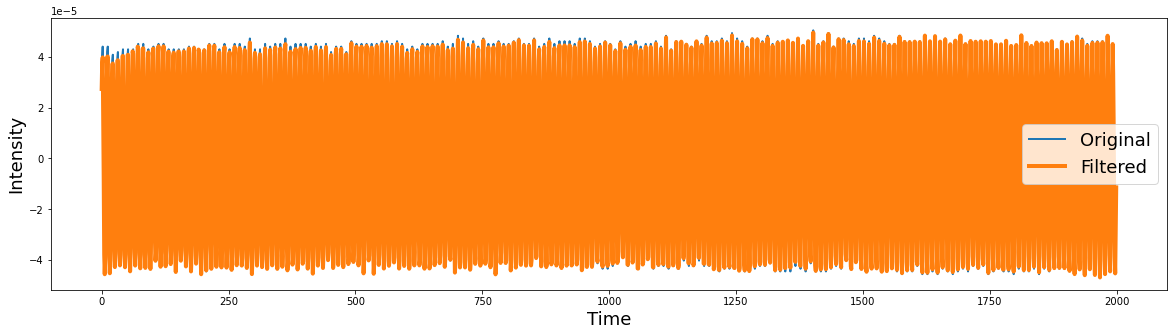

In [125]:
# Apply the filter
filtered_int = signal.lfilter(b, a, inte)
filtered_sz = signal.filtfilt(b, a, sze)

plt.figure(figsize=(20,5))
plt.plot(inte, linewidth=2)
plt.plot(filtered_int, linewidth=4)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend(['Original','Filtered'], fontsize=18)

In [268]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.lfilter(b, a, data)
    return y

In [127]:
lowpass = butter_lowpass_filter(sze, 60, 500, order=6)

In [105]:
# Filtro taglia banda, passa alta
def butter_highpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    y = signal.lfilter(b, a, data)
    return y

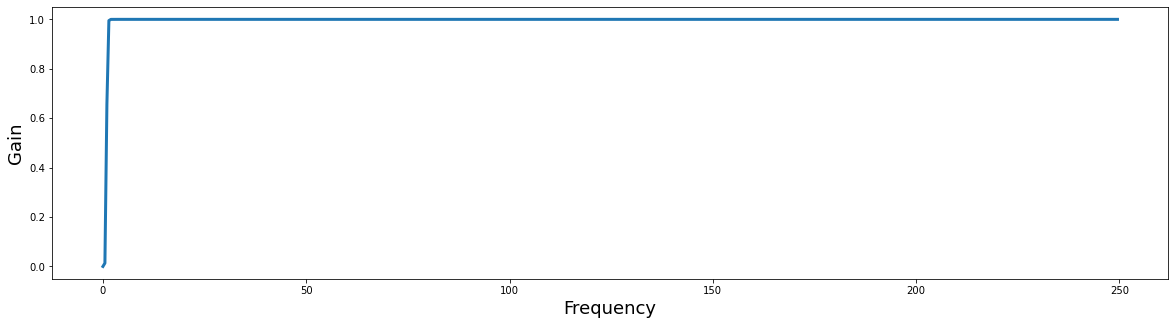

In [107]:
b, a = signal.butter(6, 1, btype='high', analog=False, fs=500)
plot_filter(b, a, 500)
cutoff=1
highpass = butter_highpass_filter(sze, cutoff, 500, order=6)

In [70]:
import matplotlib.pyplot as plt
from importlib import reload
import scipy
plt=reload(plt)

In [72]:
def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    i, u = signal.butter(order, [low, high], btype='bandstop')
    y = signal.lfilter(i, u, data)
    return y

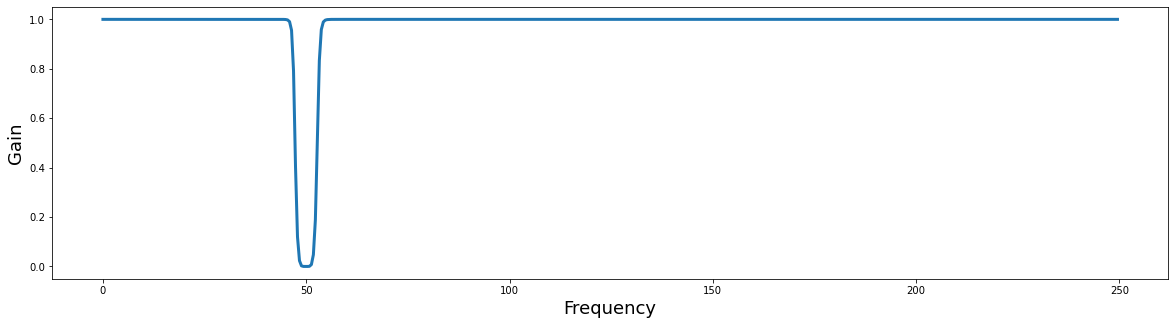

In [83]:
b, a = signal.butter(6, [47, 53], btype='bandstop', output='ba', fs=FREQ)
plot_filter(b, a, sampling_frequency)

In [89]:
lowcut=47
highcut=53

band_pass_50 = butter_bandstop_filter(sze, lowcut, highcut, FREQ, order=6)

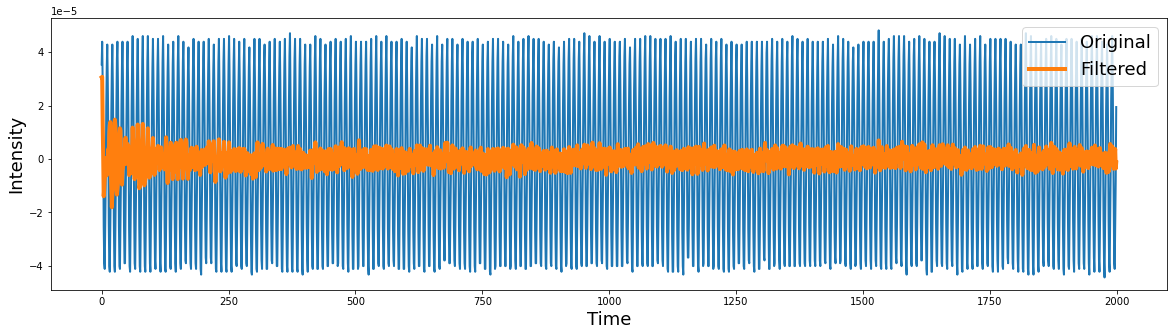

In [90]:
plt.figure(figsize=(20,5))
plt.plot(sze, linewidth=2)
plt.plot(band_pass_50, linewidth=4)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend(['Original','Filtered'], fontsize=18)

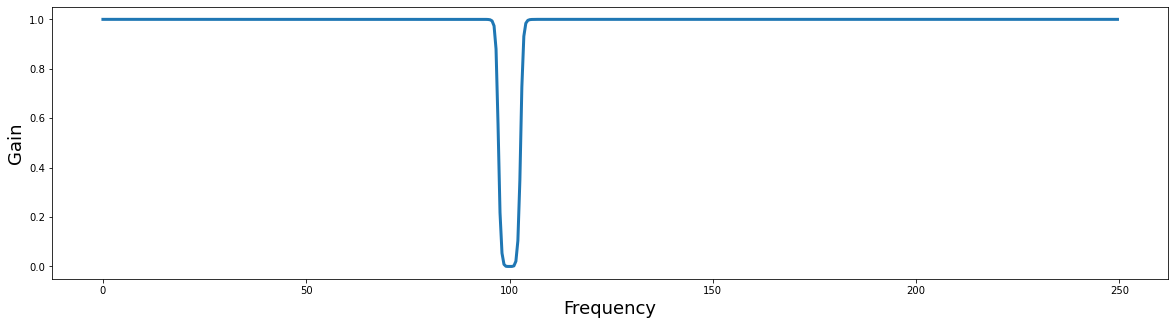

In [91]:
b, a = signal.butter(6, [97, 103], btype='bandstop', output='ba', fs=FREQ)
plot_filter(b, a, sampling_frequency)

Text(0, 0.5, 'Hz')

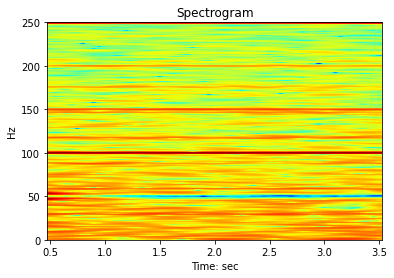

In [92]:

s,f,t,im = plt.specgram(band_pass_50,Fs=500,cmap='jet', NFFT=int(500), noverlap=int(500*0.95))
plt.title("Spectrogram")
plt.xlabel("Time: sec")
plt.ylabel("Hz")


In [93]:
band_pass_100 = butter_bandstop_filter(sze, 97, 103, FREQ, order=6)

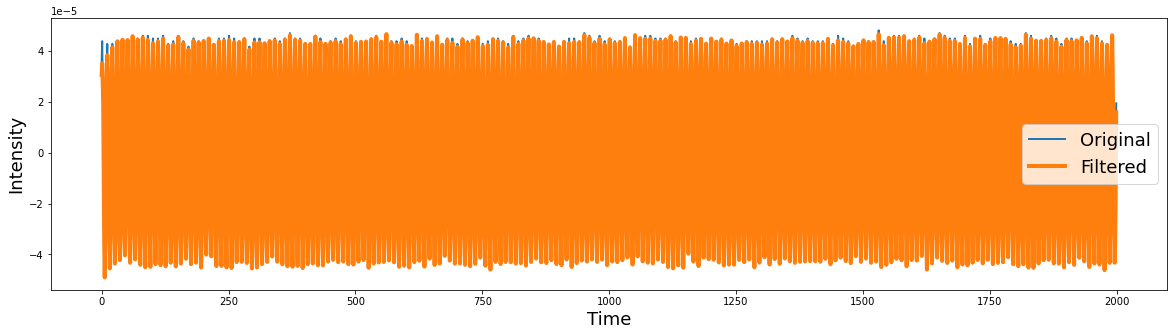

In [94]:
plt.figure(figsize=(20,5))
plt.plot(sze, linewidth=2)
plt.plot(band_pass_100, linewidth=4)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend(['Original','Filtered'], fontsize=18)

In [240]:
all = butter_bandstop_filter(sze, 97, 103, FREQ, order=6)
all = butter_bandstop_filter(all, 47, 53, FREQ, order=6)
all = butter_highpass_filter(all, 1, FREQ, order=6)

In [187]:
all_low = butter_bandstop_filter(sze, 97, 103, FREQ, order=6)
all_low = butter_bandstop_filter(all_low, 47, 53, FREQ, order=6)
all_low = butter_highpass_filter(all_low, 1, FREQ, order=6)
all_low = butter_lowpass_filter(all_low, 60, 500, order=6)

Text(0, 0.5, 'Hz')

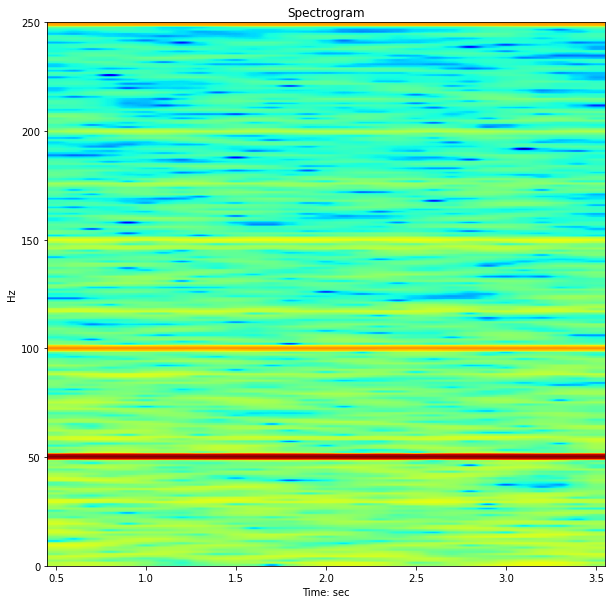

In [230]:
plt.figure(figsize=(10, 10))
s,f,t,im = plt.specgram(sze, Fs=500,cmap='jet', NFFT=int(500), noverlap=int(500*0.9))
#plt.ylim(0,120)
plt.title("Spectrogram")
plt.xlabel("Time: sec")
plt.ylabel("Hz")

In [211]:
s.shape

(251, 31)

In [163]:
y = s[:120]
y.shape

(120, 7)

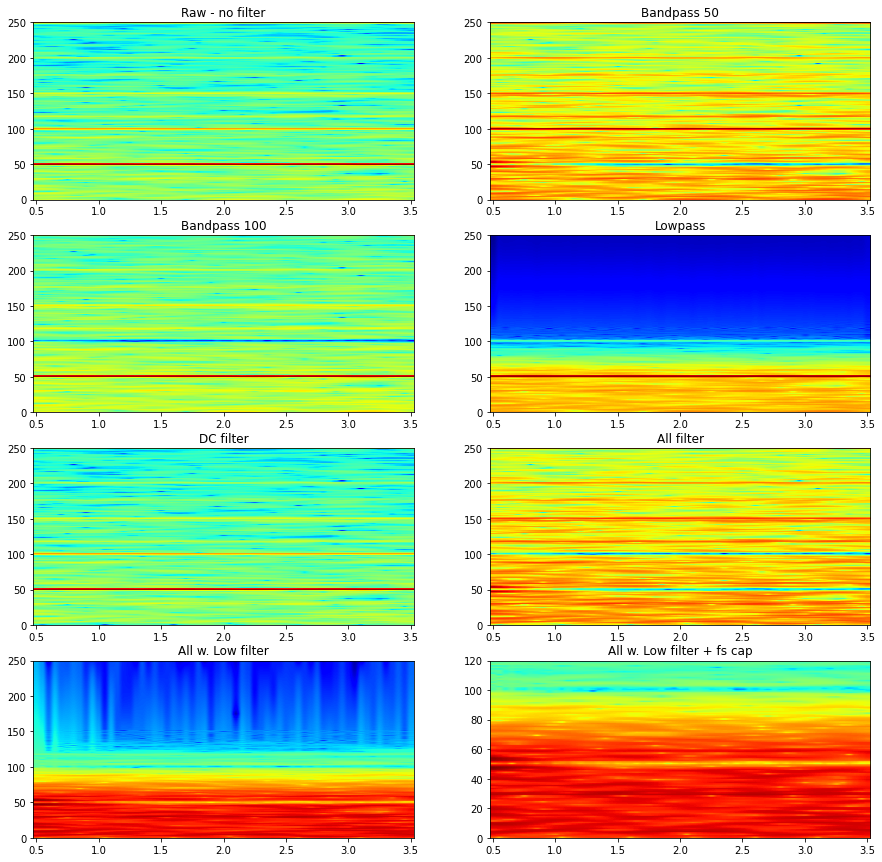

In [213]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(15,15), sharey=False, sharex = False)
Pxx, freqs, bins, im = ax1.specgram(sze, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax1.set_title('Raw - no filter')
Pxx, freqs, bins, im = ax2.specgram(band_pass_50, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax2.set_title('Bandpass 50')
Pxx, freqs, bins, im = ax3.specgram(band_pass_100, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax3.set_title('Bandpass 100')
Pxx, freqs, bins, im = ax4.specgram(lowpass, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax4.set_title('Lowpass')
Pxx, freqs, bins, im = ax5.specgram(highpass, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax5.set_title('DC filter')
Pxx, freqs, bins, im = ax6.specgram(all, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax6.set_title('All filter')
Pxx, freqs, bins, im = ax7.specgram(all_low, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax7.set_title('All w. Low filter')
Pxx, freqs, bins, im = ax8.specgram(all_low, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet', scale_by_freq=False)
ax8.axis(ymin=0, ymax=120)
ax8.set_title('All w. Low filter + fs cap')


for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Hz')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [245]:
all_inte = butter_bandstop_filter(inte, 97, 103, FREQ, order=6)
all_inte = butter_bandstop_filter(all_inte, 47, 53, FREQ, order=6)
all_inte = butter_highpass_filter(all_inte, 1, FREQ, order=6)

In [274]:
den_sz = denoise_wavelet(np.array(sze).astype(np.float),wavelet='db6', method='BayesShrink', mode='hard',rescale_sigma=True, multichannel=False, wavelet_levels=1)
den_inte = denoise_wavelet(np.array(inte).astype(np.float),wavelet='db6', method='BayesShrink', mode='soft',rescale_sigma=True, multichannel=False, wavelet_levels=1)

all_den_sz = butter_bandstop_filter(den_sz, 97, 103, FREQ, order=6)
all_den_sz = butter_bandstop_filter(all_den_sz, 47, 53, FREQ, order=6)
all_den_sz = butter_highpass_filter(all_den_sz, 1, FREQ, order=6)

all_den_inte = butter_bandstop_filter(den_inte, 97, 103, FREQ, order=6)
all_den_inte = butter_bandstop_filter(all_den_inte, 47, 53, FREQ, order=6)
all_den_inte = butter_highpass_filter(all_den_inte, 1, FREQ, order=6)

all_low_sz = butter_bandstop_filter(sze, 97, 103, FREQ, order=6)
all_low_sz = butter_bandstop_filter(all_low_sz, 47, 53, FREQ, order=6)
all_low_sz = butter_highpass_filter(all_low_sz, 1, FREQ, order=6)
all_low_sz = butter_lowpass_filter(all_low_sz, 100, 500, order=1)

all_low_inte = butter_bandstop_filter(inte, 97, 103, FREQ, order=6)
all_low_inte = butter_bandstop_filter(all_low_inte, 47, 53, FREQ, order=6)
all_low_inte = butter_highpass_filter(all_low_inte, 1, FREQ, order=6)
all_low_inte = butter_lowpass_filter(all_low_inte, 100, 500, order=1)

(0.253, 3.745, 0.0, 120.0)

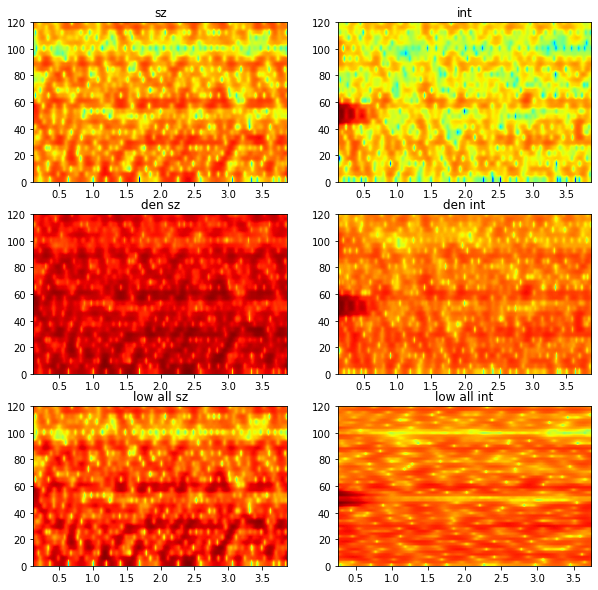

In [291]:
nft = int(FREQ/4)
nover = int(nft*0.95)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10,10), sharey=False, sharex = False)
Pxx, freqs, bins, im = ax1.specgram(all, NFFT=nft, Fs=500, noverlap=nover, cmap='jet')
ax1.set_title('sz')
ax1.axis(ymin=0, ymax=120)
Pxx, freqs, bins, im = ax2.specgram(all_inte, NFFT=nft, Fs=500, noverlap=nover, cmap='jet')
ax2.set_title('int')
ax2.axis(ymin=0, ymax=120)

Pxx, freqs, bins, im = ax3.specgram(all_den_sz, NFFT=nft, Fs=500, noverlap=nover, cmap='jet')
ax3.set_title('den sz')
ax3.axis(ymin=0, ymax=120)
Pxx, freqs, bins, im = ax4.specgram(all_den_inte, NFFT=nft, Fs=500, noverlap=nover, cmap='jet')
ax4.set_title('den int')
ax4.axis(ymin=0, ymax=120)

Pxx, freqs, bins, im = ax5.specgram(all_low_sz, NFFT=nft, Fs=500, noverlap=nover, cmap='jet')
ax5.set_title('low all sz')
ax5.axis(ymin=0, ymax=120)
Pxx, freqs, bins, im = ax6.specgram(all_low_inte, NFFT=256, Fs=500, noverlap=int(256*0.99), cmap='jet')
ax6.set_title('low all int')
ax6.axis(ymin=0, ymax=120)




In [38]:
Fs = 500       # Define the sampling frequency,
interval = 500   # ... the interval size,
overlap = interval * 0.95  # ... and the overlap intervals

/var/folders/0v/m6wt8rqj7s1dcljdyjrdfxmw0000gn/T/ipykernel_8701/142312461.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, Sxx, norm=normalize_color, cmap='jet')# Plot the result


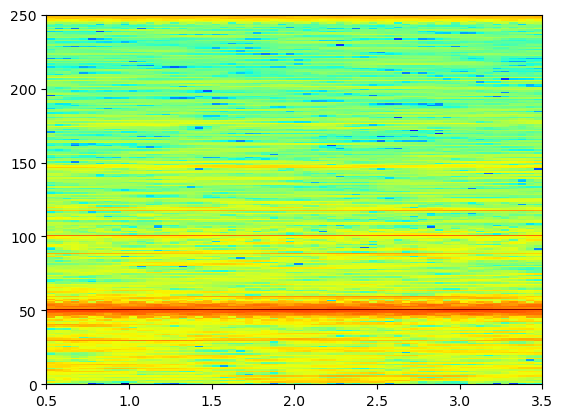

In [39]:
import matplotlib
import pylab
import matplotlib.colors as colors
from scipy.stats import lognorm

f, t, Sxx = signal.spectrogram(np.array(inte), fs=Fs, nperseg=interval, noverlap=overlap)

normalize_color= colors.LogNorm(vmin=np.amin(Sxx), vmax=np.amax(Sxx))
plt.pcolormesh(t, f, Sxx, norm=normalize_color, cmap='jet')# Plot the result
#plt.savefig("hi2.png")


/var/folders/0v/m6wt8rqj7s1dcljdyjrdfxmw0000gn/T/ipykernel_8701/2612149833.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.abs(Zxx), cmap='jet')# Plot the result


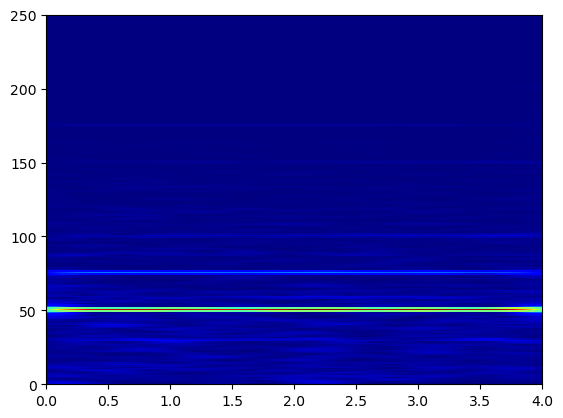

In [40]:
f, t, Zxx = signal.stft(den_inte, fs=Fs, nperseg=FREQ, noverlap=FREQ*0.99)
plt.pcolormesh(t, f, np.abs(Zxx), cmap='jet')# Plot the result

(array([[5.49003766e-14, 2.08523249e-15, 5.19470508e-15, ...,
         3.32670532e-15, 7.69669873e-16, 2.34051345e-16],
        [5.92613998e-14, 1.42018500e-14, 8.11503575e-15, ...,
         1.33686458e-14, 4.79594557e-15, 1.24976894e-15],
        [5.00652147e-14, 2.11405356e-14, 2.58543052e-15, ...,
         6.25268038e-14, 8.65616222e-15, 3.67517278e-15],
        ...,
        [2.99151731e-25, 9.61646787e-26, 5.48177472e-27, ...,
         2.15754452e-27, 1.37841985e-26, 7.33300049e-28],
        [2.95042306e-25, 9.27798149e-26, 1.62773015e-27, ...,
         1.06421262e-27, 1.25866358e-26, 5.68541878e-28],
        [1.46839610e-25, 4.58289915e-26, 1.74032386e-28, ...,
         3.51331300e-28, 6.09537569e-27, 2.58763475e-28]]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,

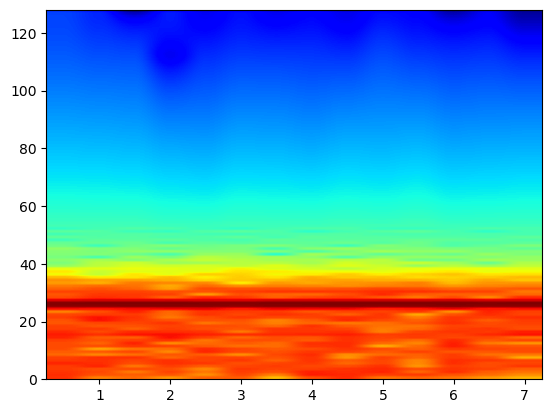

In [41]:
plt.specgram(filtered_int, cmap='jet', Fs=256)
#plt.savefig("hi.png")

In [42]:
def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    i, u = signal.butter(order, [low, high], btype='bandstop')
    y = signal.lfilter(i, u, data)
    return y

In [43]:
fs=256
lowcut=117
highcut=123
y=butter_bandstop_filter(den_sz, lowcut, highcut, fs, order=6)

lowcut=57
highcut=63
y=butter_bandstop_filter(y, lowcut, highcut, fs, order=6)

In [44]:
freqs, bins,Pxx =signal.spectrogram(y, nfft=256, fs=256, return_onesided=True, noverlap=256*0.95)

In [45]:
Pxx = np.delete(Pxx, np.s_[117:123+1], axis=0)
Pxx = np.delete(Pxx, np.s_[57:63+1], axis=0)
Pxx = np.delete(Pxx, 0, axis=0)

In [46]:
freqs = np.arange(Pxx.shape[0])

/var/folders/0v/m6wt8rqj7s1dcljdyjrdfxmw0000gn/T/ipykernel_8701/1495177456.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(freqs, bins, 10*np.log10(np.transpose(Pxx)),cmap=plt.cm.jet)


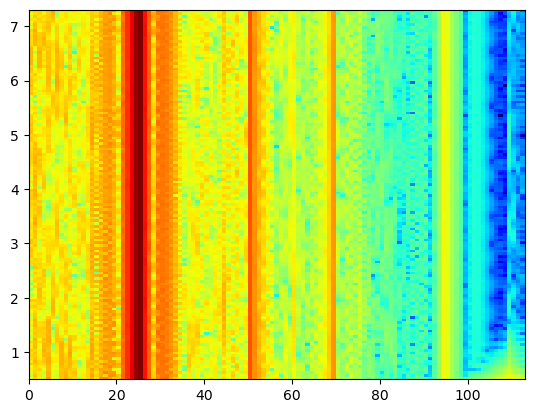

In [47]:
plt.pcolormesh(freqs, bins, 10*np.log10(np.transpose(Pxx)),cmap=plt.cm.jet)

In [48]:
result=(10*np.log10(np.transpose(Pxx))-(10*np.log10(np.transpose(Pxx))).min())/(10*np.log10(np.transpose(Pxx))).ptp()

/var/folders/0v/m6wt8rqj7s1dcljdyjrdfxmw0000gn/T/ipykernel_8701/42712137.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(freqs, bins, result,cmap=plt.cm.jet)


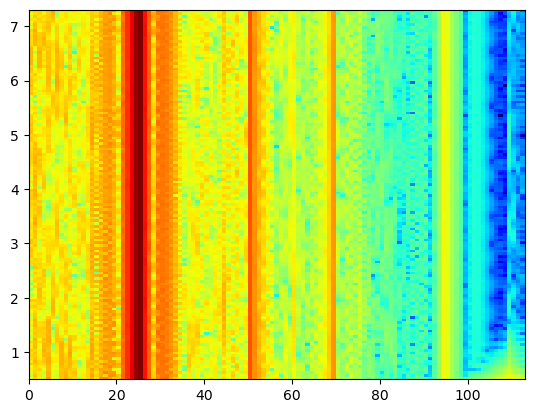

In [49]:
freqs = np.arange(result.shape[1])
plt.pcolormesh(freqs, bins, result,cmap=plt.cm.jet)

In [50]:
plt.style.use('default')
plt.specgram(filtered, Fs=256, NFFT=128, noverlap=256/8, cmap='jet')


NameError: name 'filtered' is not defined

In [ ]:
datetime.fromtimestamp(-2208984384000/1000).strftime('%H:%M:%S')

'02:13:36'

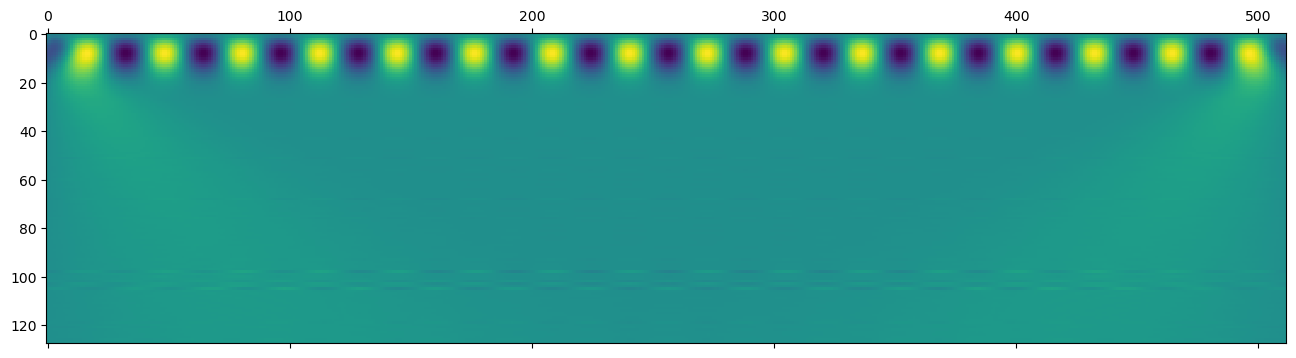

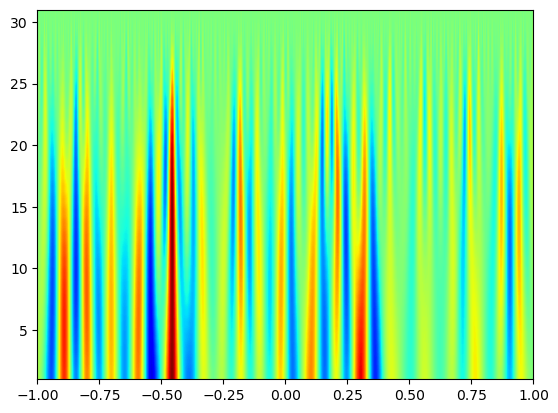

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(512)
y = np.sin(2*np.pi*x/32)
coef, freqs=pywt.cwt(y,np.arange(1,129),'gaus1')
plt.matshow(coef) # doctest: +SKIP
plt.show() # doctest: +SKIP

import pywt
import numpy as np
import matplotlib.pyplot as plt
t = np.linspace(-1, 1, 200, endpoint=False)
sig  = np.cos(2 * np.pi * 7 * t) + np.real(np.exp(-7*(t-0.4)**2)*np.exp(1j*2*np.pi*2*(t-0.4)))
widths = np.arange(1, 31)
cwtmatr, freqs = pywt.cwt(inte, widths, 'mexh')
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='jet', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
plt.show() # doctest: +SKIP